<a href="https://colab.research.google.com/github/harshith-sunkoji/online-course-registration-source-code/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import os
import pathlib
import skimage.io as io
import skimage.transform as tf
import skimage.color as color
import torch

In [7]:
!pip install haroun
# import my Library (Pytorch Framework)
from haroun import Data, Model, ConvPool
from haroun.augmentation import augmentation
from haroun.losses import rmse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for haroun: filename=Haroun-0.1.5-py3-none-any.whl size=6043 sha256=e8e25c1aa03e4ad5ae0ae3985e35d0809798f5f0ba4b01899ab329baea6a8168
  Stored in directory: /root/.cache/pip/wheels/20/9e/37/e37982fe709d9ebd194cd57c28f2ac9a7dfc9624b202d2deff
Successfully built haroun


In [20]:
def load_data():
    path = pathlib.Path.cwd().parent / "/content"
    path = path / "real_and_fake_face"
    images = []
    labels = []


    for directory in os.listdir(path):
        data_path = path / directory
        
        for im in os.listdir(data_path)[:]:
            image = io.imread(f"{data_path}/{im}")
            image = tf.resize(image, (64, 64))
            images.append(image)
            if directory == "training_fake":
                labels.append("fake")
            elif directory == "training_real":
                labels.append("real")
    

    images = np.array(images)
    labels = np.array(labels)

    images, labels = augmentation(images, labels, flip_y=True, flip_x=True, brightness=True)

    return images, labels

In [21]:
classes = {'real': 0, 'fake': 1}
data = Data(loader=load_data(), classes=classes)
data.shape()

Data loaded successfully :)
Images shape: (12972, 64, 64, 3) Labels shape: (12972,)



In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.dataset(split_size=0.05, shuffle=True, random_state=42,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True, one_hot=True, device=device)

Train tensor shape: torch.Size([12323, 3, 64, 64]), torch.Size([12323, 2])
Test tensor shape: torch.Size([324, 3, 64, 64]), torch.Size([324, 2])
Validation tensor shape: torch.Size([325, 3, 64, 64]), torch.Size([325, 2])

Dataset generated successfully :)


In [24]:
class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(3, affine=False)
        self.layer1 = ConvPool(in_features=3, out_features=8)
        self.layer2 = ConvPool(in_features=8, out_features=16)
        self.layer3 = ConvPool(in_features=16, out_features=32)
        self.layer4 = ConvPool(in_features=32, out_features=64)
        self.layer5 = ConvPool(in_features=64, out_features=128)
        self.layer6 = ConvPool(in_features=128, out_features=256)
        
        

        self.net = torch.nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=2)


        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)
        return X

In [29]:
net = Network()
AntiSpoofClassifier = Model(net, "adam", rmse, device)
AntiSpoofClassifier.train(train_data=(data.train_inputs, data.train_outputs),
                          val_data=(data.val_inputs, data.val_outputs),
                          epochs=50, patience=20, batch_size=100, learning_rate=1.0E-3)

Model initialized succssefully :)

Train loop:

	Epoch: 1/50,  Train Loss: 0.0735,  Val Loss: 0.0235
	Epoch: 2/50,  Train Loss: 0.0455,  Val Loss: 0.08 - No improvement -> Remaining patience: 19
	Epoch: 3/50,  Train Loss: 0.0386,  Val Loss: 0.0231
	Epoch: 4/50,  Train Loss: 0.0025,  Val Loss: 0.000694
	Epoch: 5/50,  Train Loss: 0.000686,  Val Loss: 0.000857 - No improvement -> Remaining patience: 19
	Epoch: 6/50,  Train Loss: 0.000521,  Val Loss: 0.000573
	Epoch: 7/50,  Train Loss: 0.00035,  Val Loss: 0.000479
	Epoch: 8/50,  Train Loss: 0.000339,  Val Loss: 0.000538 - No improvement -> Remaining patience: 19
	Epoch: 9/50,  Train Loss: 0.00026,  Val Loss: 0.000522 - No improvement -> Remaining patience: 18
	Epoch: 10/50,  Train Loss: 0.000234,  Val Loss: 0.000192
	Epoch: 11/50,  Train Loss: 0.000212,  Val Loss: 0.000241 - No improvement -> Remaining patience: 19
	Epoch: 12/50,  Train Loss: 0.000209,  Val Loss: 0.000397 - No improvement -> Remaining patience: 18
	Epoch: 13/50,  Train Los

In [30]:
AntiSpoofClassifier.evaluate(test_data=(data.test_inputs, data.test_outputs))


Test accuracy:100%
Correct predictions: 324, Wrong predictions: 0


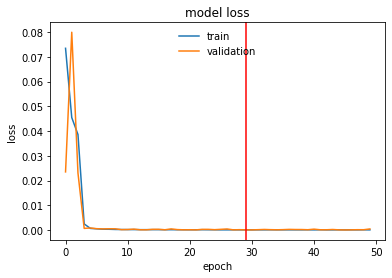


Checkpoint saved successfully :)


In [31]:
AntiSpoofClassifier.plot()
AntiSpoofClassifier.save(path="./", checkpoint_name="module")